# Image search using SIFT

Let's think about information retrieval in the context of image search. How can we find images similar to a query in a fast way (faster than doing pair-wise comparison with all images in a database)? How can we identify same objects taken in slightly different contexts? 

One way to do this is to find special points of interest in every image, so called keypoints (or descriptors), which characterize the image and which are more or less invariant to scaling, orientation, illumination changes, and some other distortions. There are several algorithms available that identify such keypoints, and today we will focus on [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). 

Your task is to apply SIFT to a dataset of images and enable similar images search.

## 1. Get dataset

We will use `Caltech 101` dataset, download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). It consists of pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. The size of each image is roughly 300 x 200 pixels.

In [ ]:
!pip install gdown
# Colab specific code
!gdown --id 137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp

In [1]:
import shutil
shutil.unpack_archive("101_ObjectCategories.tar.gz", ".")

## 2. SIFT example

Below is an example how to extract SIFT keyponts using `opencv`. [This](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) is a dedicated tutorial, and [this](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) is another tutorial you may need to find matches between two images (use in your code `cv.drawMatches()` function to display keypoint matches).

In [ ]:
!pip install opencv-python opencv-contrib-python

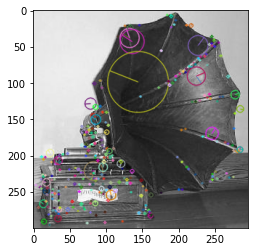

In [3]:
import cv2 as cv
from matplotlib import pyplot as plt

img_dir = '101_ObjectCategories'
img = cv.imread(img_dir + '/gramophone/image_0018.jpg')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(gray, None)
img=cv.drawKeypoints(gray, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

## 3. Index of keypoints

Let's suppose we've found image descriptors. How do we find similar images, having this information? In our case the descriptors are 128-dimensional vectors per keypoint, and there can be hundreds of such points. To enable fast search of similar images, you will index descriptors of all images using some data structure for approximate nearest neighbors search, such as Navigable Small World, Annoy, FAISS, .... Then, for a new (query) image you will compute its descriptors, and for each of them find `k` nearest neighbor descriptors from index (using Euclidean or Cosine distance). Finally, you will sort images (retrieved from neighbor descriptors) by frequency with which they appear in `k` nearest neighbors (more matches -- higher the rank).

### 3.1. Build an index

Read all images, saving category information. For every image generate SIFT descriptors and index them using HNSW from [`nmslib`](https://github.com/nmslib/nmslib), [FAISS](https://github.com/facebookresearch/faiss), [Annoy](https://github.com/spotify/annoy) or whatever.

In [ ]:
!pip install annoy

In [26]:
from os import listdir
from tqdm import tqdm 
from annoy import AnnoyIndex

sift = cv.xfeatures2d.SIFT_create()

index = AnnoyIndex(128, 'angular')

dataset = []
for category in tqdm(listdir(img_dir)):
    files = listdir(img_dir + "/" + category)
    for file in files[:30]:
        filename = img_dir + '/' + category + '/' + file
        img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
        kp, descriptors = sift.detectAndCompute(img, None)
        for vec in descriptors[:32]:
        
        
            # ADD A VECTOR TO AN INDEX
            # TODO
            
            dataset.append([category, filename])

index.build(50)

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [01:31<00:00,  1.11it/s]


True

### 3.2. Implement search function

Implement a function which returns `k` neighbours (file names) sorted by similarity for a given query image name.

In [79]:
from collections import Counter

def anns(index, dataset, imagename, k):
    img = cv.imread(imagename, cv.IMREAD_GRAYSCALE)
    kp, descriptors = sift.detectAndCompute(img, None)
    
    ## TODO
    
    return None


# finds query image in the result, as it is indexed
filename = img_dir + '/strawberry/image_0022.jpg'
anns(index, dataset, filename, 5)

[('101_ObjectCategories/strawberry/image_0022.jpg', 34),
 ('101_ObjectCategories/inline_skate/image_0023.jpg', 3),
 ('101_ObjectCategories/dollar_bill/image_0017.jpg', 2),
 ('101_ObjectCategories/barrel/image_0005.jpg', 2),
 ('101_ObjectCategories/brontosaurus/image_0003.jpg', 2)]

# Images semantics

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt

In [ ]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

# Images
img = 'https://ultralytics.com/images/zidane.jpg'  # or file, Path, PIL, OpenCV, numpy, list
img = 'https://innopolis.university/upload/landing/c9d/image_3.1@2x.jpg'
# Inference
results = model(img)

print("Result type", type(results))
pandas_detections_df = results.pandas().xyxy[0]

pandas_detections_df

## 1. Check the model works for a Caltech dataset

In [108]:
### 